# 0. Introuction
This notebook will do basic Twitter sentiment analysis. As show in below image, we will be performing few text cleaning and model building techniques. 
The flow of the notebook 
1. Importing libs
2. Importing Twitter Dataset and basic checks
3. Preprocessing the text data <br>
    3.1 Converting to lower case <br>
    3.2 Stop word handling <br>
    3.3 Removing URLs and Numbers <br>
    3.4 removing certain patterns <br>
    3.5 Tokenizing the text <br>
    3.6 Stemming. <br>
    3.7 Lemmatization. <br>
4. Exploratory Data Analysis using WordCloud
5. Model Building 
    5.1 Data Preperation for modeling <br>
    5.2 Data Vectorizing <br>
    5.3 Naive bayes : Model building <br>
    5.4 Random Forest : Model building <br>
    5.5. Models comparison <br>

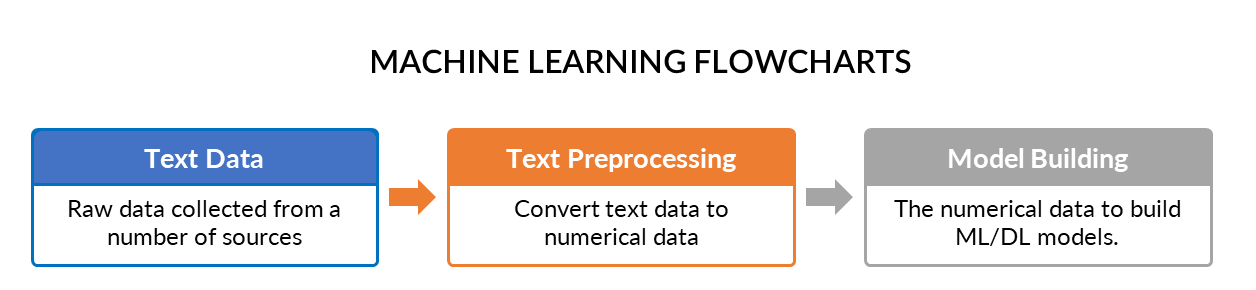




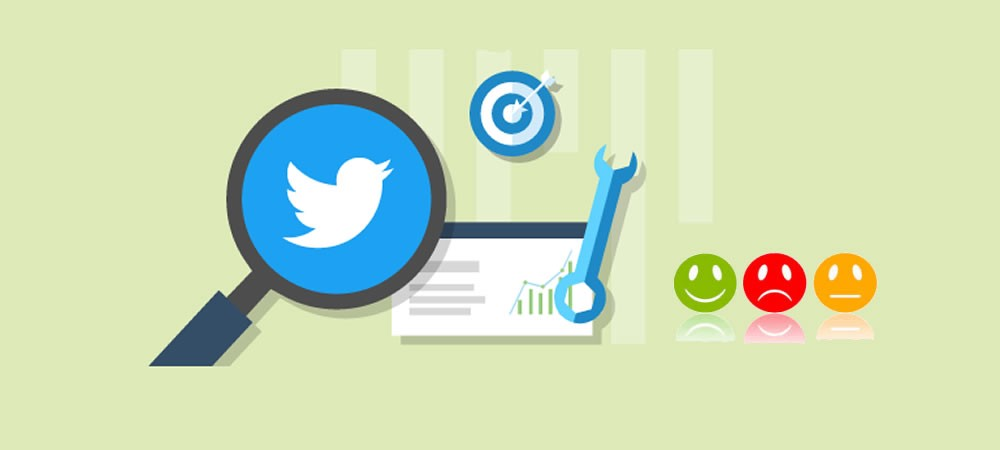

# 1. Importing libs

In [34]:
import pandas as pd
import numpy as np
import re #used as a regular expression to find particular patterns and process it
import string #used to obtain information in the string and manipulate the string overall
import warnings
import re
from wordcloud import WordCloud
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
import nltk #a natural language processing toolkit module associated in anaconda
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prashant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Importing Twitter Dataset and basic checks

In [35]:
DATASET_COLUMNS=['target','ids','date','query','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('tweetir.csv',encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.tail(5)

,target,ids,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [36]:
# Getting Null Values Count

df.isnull().sum()

target    0
ids       0
date      0
query     0
user      0
text      0
dtype: int64

# Getting Dataset info



In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [38]:
# Postive review is marked as 4, changing it to 1 and Negative review is 0.

df['target'] = df['target'].replace(4,1)

Negative    800000
Positive    800000
Name: target, dtype: int64


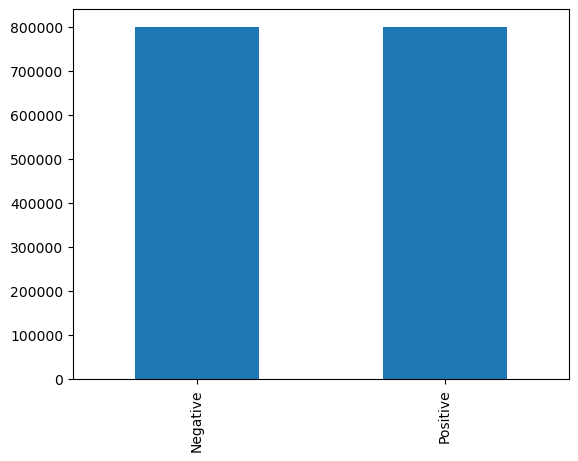

In [12]:
# Visualising the distribution of the target variable.

sentiment = {0:"Negative", 1:"Positive"}
print(df.target.apply(lambda x: sentiment[x]).value_counts())
df.target.apply(lambda x: sentiment[x]).value_counts().plot(kind = 'bar')
plt.show()

In [39]:
# Aim is to find a sentiment of the text based on the tweet, for this only target and text are enough.

data=df[['text','target']]
data.head(2)

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0


In [40]:
# can use entire dataset for this Analysis or select a subset of 1.6 Million tweets. 
# In this using 50k entires. 
# in the process of sampling maintaining the correct target ratio is very imp.

data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

data_pos = data_pos.iloc[:int(25000)]
data_neg = data_neg.iloc[:int(25000)]

dataset = pd.concat([data_pos, data_neg])

print(len(dataset))
dataset.head(2)

50000


,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1


# 3. Preprocessing the text data 

## 3.1 Converting to lower case 

In [41]:
# Converting to Lower case

dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

24995    is sad that it is raining... no softball for m...
24996                               last day of vacation. 
24997    good morning! its a beautiful day, too bad i'm...
24998    night all. love yas. hahahahahah btw... vodka ...
24999       why do i have to go back to school tomorrow?? 
Name: text, dtype: object

## 3.2 Stop word handling

In [42]:
# Defining stopwords

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [43]:
# Removing Stopwords

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].tail()

24995                   sad raining... no softball today!!
24996                                   last day vacation.
24997    good morning! beautiful day, bad i'm gonna spe...
24998    night all. love yas. hahahahahah btw... vodka ...
24999                            go back school tomorrow??
Name: text, dtype: object

In [44]:
# Removing stop words using nltk lib

#Tokenization of text
tokenizer=ToktokTokenizer() 

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#Removing standard english stopwords like prepositions, adverbs
stop = set(stopwords.words('english'))
print("NLTK stop word lists \n")
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


NLTK stop word lists 

{'having', "hasn't", 'y', "mightn't", "needn't", "haven't", 'won', 'is', 'being', 'other', 'from', "you're", 'that', 'hasn', 'am', 'against', 'here', 'down', 'only', 'it', 'into', 'if', 'before', 'ours', 'had', 'did', "should've", 'under', 'do', 'needn', 'below', 'in', "wouldn't", 'what', 'while', 'over', 'aren', 'any', 'yours', 'whom', 'why', 'further', 'all', 'as', 'between', 'been', 'o', 'and', 'out', 'at', 'when', 'their', 'about', "couldn't", 'again', 'but', 'your', 'hers', 'on', 'himself', 'herself', 'with', 'were', 'can', 'they', 'once', 'have', 'an', "doesn't", 'd', 'now', "won't", 'mightn', 'theirs', 'you', "mustn't", 'most', 'then', "that'll", 'this', "you'd", 'yourself', 'itself', 'up', 'off', 'wasn', 's', 're', "isn't", 'a', 'don', 'by', 'to', 'i', 'who', 'above', 'doesn', 'we', 'same', 'after', 'his', 'where', 'mustn', "she's", 'themselves', "didn't", "you've", 'has', 'of', 'during', 'didn', 'shan', 'are', 'not', 'does', 'both', 't', 'how', 'so', 'ea

In [45]:
dataset['text']=dataset['text'].apply(remove_stopwords)
dataset['text'].tail()

24995                   sad raining ... softball today ! !
24996                                  last day vacation .
24997    good morning ! beautiful day , bad ' gonna spe...
24998    night all. love yas. hahahahahah btw ... vodka...
24999                           go back school tomorrow? ?
Name: text, dtype: object

## 3.3 Removing URLs and Numbers

In [46]:
# removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

800000              love @health4uandpets u guys r best ! !
800001    im meeting one besties tonight ! cant wait ! !...
800002    @darealsunisakim thanks twitter add , sunisa !...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [47]:
# removing numbers 

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].head()

800000               love @healthuandpets u guys r best ! !
800001    im meeting one besties tonight ! cant wait ! !...
800002    @darealsunisakim thanks twitter add , sunisa !...
800003    sick really cheap hurts much eat real food plu...
800004                       @lovesbrooklyn effect everyone
Name: text, dtype: object

## 3.4 removing certain patterns

In [48]:
# fucntion to removes pattern in the input text.

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt


In [49]:
# remove twitter handles (@user)

dataset['text'] = np.vectorize(remove_pattern)(dataset['text'], "@[\w]*")
dataset.head()

,text,target
800000,love u guys r best ! !,1
800001,im meeting one besties tonight ! cant wait ! !...,1
800002,"thanks twitter add , sunisa ! got meet hin sh...",1
800003,sick really cheap hurts much eat real food plu...,1
800004,effect everyone,1


In [50]:
# remove special characters, numbers and punctuations

dataset['text'] = dataset['text'].str.replace("[^a-zA-Z#]", " ")
dataset.head()

,text,target
800000,love u guys r best,1
800001,im meeting one besties tonight cant wait ...,1
800002,thanks twitter add sunisa got meet hin sh...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,effect everyone,1


In [51]:
# remove short words

dataset['text'] = dataset['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
dataset.head()

,text,target
800000,love guys best,1
800001,meeting besties tonight cant wait girl talk,1
800002,thanks twitter sunisa meet show area sweetheart,1
800003,sick really cheap hurts much real food plus fr...,1
800004,effect everyone,1


## 3.5 Tokenizing the text
 

In [52]:
# Tokenizing the text

tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000                                   [love, guys, best]
800001    [meeting, besties, tonight, cant, wait, girl, ...
800002    [thanks, twitter, sunisa, meet, show, area, sw...
800003    [sick, really, cheap, hurts, much, real, food,...
800004                                   [effect, everyone]
Name: text, dtype: object

## 3.6 Stemming.
 

In [53]:
# Applying Stemming

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000                                   [love, guys, best]
800001    [meeting, besties, tonight, cant, wait, girl, ...
800002    [thanks, twitter, sunisa, meet, show, area, sw...
800003    [sick, really, cheap, hurts, much, real, food,...
800004                                   [effect, everyone]
Name: text, dtype: object

## 3.7 Lemmatization.
 

In [54]:
# Applying Lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return ' ' .join(text)
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Prashant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Prashant\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,text,target
800000,love guy best,1
800001,meeting besties tonight cant wait girl talk,1
800002,thanks twitter sunisa meet show area sweetheart,1
800003,sick really cheap hurt much real food plus fri...,1
800004,effect everyone,1


# 4. Exploratory Data Analysis using WordCloud

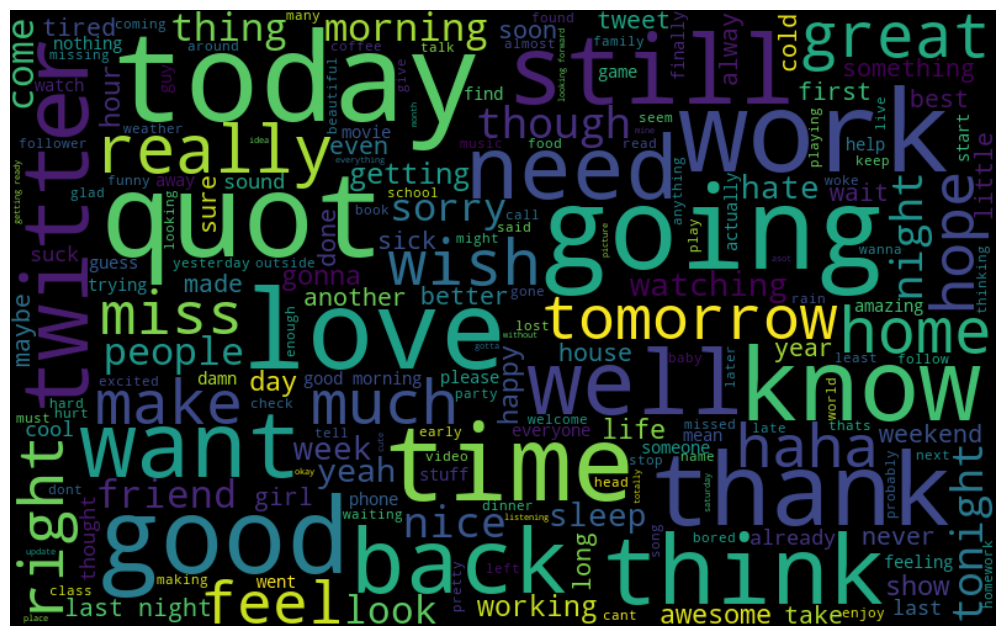

In [56]:
# visualize the frequent words

all_words = " ".join([sentence for sentence in dataset['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

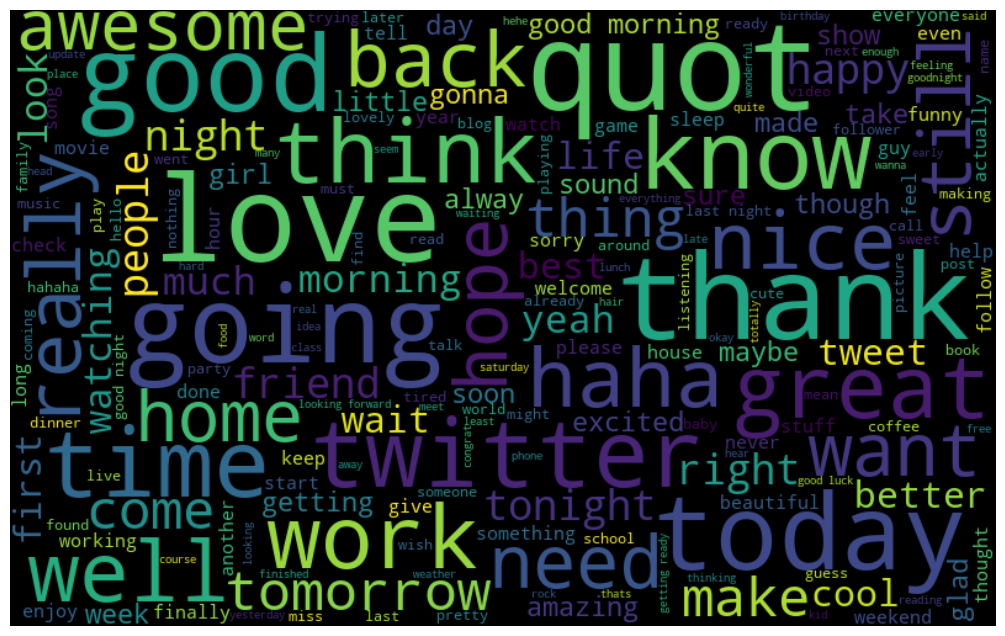

In [57]:
# frequent words visualization for +ve

all_words = " ".join([sentence for sentence in dataset['text'][dataset['target']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

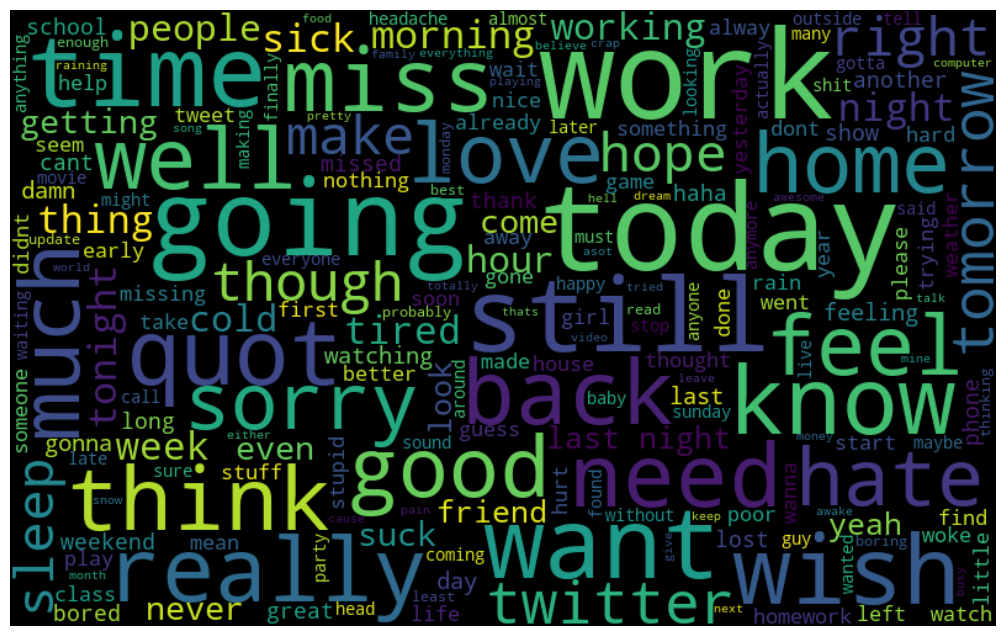

In [58]:
# frequent words visualization for -ve

all_words = " ".join([sentence for sentence in dataset['text'][dataset['target']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 5. Model Building 

## 5.1 Data Preperation for modeling

In [29]:
# Input Feature and Label

X = dataset.text
y = dataset.target

In [30]:
# Splitting our data into Train and Test

X_train,X_val,y_train,y_val = train_test_split(X, y, test_size = 0.25, random_state = 42)

## 5.2 Data Vectorizing 

In [31]:
# TFIDF : Extracting Tf-idf features

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.90, min_df=0.02, max_features=1000, stop_words='english')

tfidf.fit(list(X_train) + list(X_val))
X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [32]:
# Count Vector approach (Bag of words approach)
# PS: We are not building any models using this approach as we are doing with Tf-IDF.

from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
count_vec.fit(list(X_train) + list(X_val))

X_train_count_vec = count_vec.transform(X_train)
X_val_count_vec = count_vec.transform(X_val)

In [33]:
scores_dict_tfid = {}

## 5.3 Naive bayes : Model building

In [34]:
# Naive bayes using Tf-idf features

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred_nb, y_val))

naive bayes tfidf accuracy 0.55672


In [35]:
scores_dict_tfid['Multinomial Naive Bayes(Tfid)'] = accuracy_score(y_pred_nb, y_val)

<Axes: >

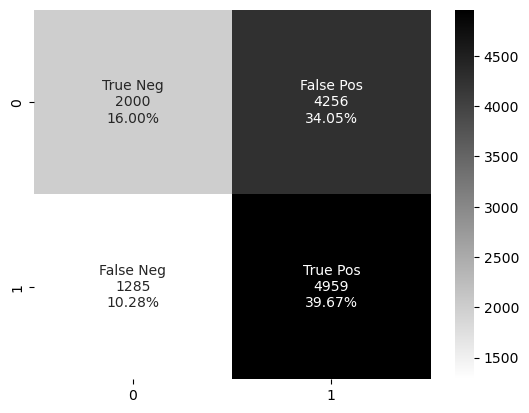

In [36]:
cf_matrix_model = confusion_matrix(y_val, y_pred_nb)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_model.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_model.flatten()/np.sum(cf_matrix_model)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_model, annot=labels, fmt='', cmap='binary')

## 5.4 Random Forest : Model building

In [37]:
# Random Forest using Tf-idf features

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tfidf,y_train)
y_pred_rf = rf.predict(X_val_tfidf)
print('Random forest tfidf accuracy %s' % accuracy_score(y_pred_rf, y_val))

Random forest tfidf accuracy 0.5708


In [38]:
scores_dict_tfid['Random Forest(tfid)'] = accuracy_score(y_pred_rf, y_val)

<Axes: >

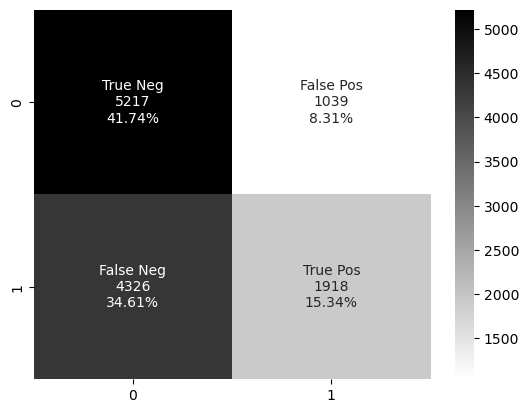

In [39]:
cf_matrix_model = confusion_matrix(y_val, y_pred_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_model.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_model.flatten()/np.sum(cf_matrix_model)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_model, annot=labels, fmt='', cmap='binary')

## 5.5. Models comparison

In [40]:
# Random forest seems working well, but to get better result, we need to try with complete data and further analysis.

scores_dict_tfid

{'Multinomial Naive Bayes(Tfid)': 0.55672, 'Random Forest(tfid)': 0.5708}

### ******** END *********